In [1]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.integrate import solve_ivp

Import data points from pseudotime

In [3]:
# Dataset strings
dataset_strings = ["1-Pastushenko"]

# Condition strings
pastushenko_condition = ["Pastushenko"]
condition_strings = pastushenko_condition

In [4]:
# File strings
pseudotime_str = " - Pseudotime - 12 bins, cropped.csv"
stdev_str = " - Pseudotime - 12 bins, cropped, stdev.csv"

pastushenko_files_pseudotime = [pastushenko_condition[0]+pseudotime_str]
pastushenko_files_stdev = [pastushenko_condition[0]+stdev_str]

pseudotimeFiles = pastushenko_files_pseudotime
stdevFiles = pastushenko_files_stdev
dataset_strings_pseudotime = dataset_strings

# Import data

pseudotime_dfs = []
stdev_dfs = []

for idx, currDatasetStr in enumerate(dataset_strings_pseudotime):
    os.chdir("ODE Model/Data/"+currDatasetStr+"/")
    
    currDf = pd.read_csv(pseudotimeFiles[idx], index_col=0)
    new_index = np.linspace(0, 10, len(currDf.index)).round(2)
    currDf = currDf.set_index(new_index)
    pseudotime_dfs.append(currDf)
    
    currDf = pd.read_csv(stdevFiles[idx], index_col=0)
    new_index = np.linspace(0, 10, len(currDf.index)).round(2)
    currDf = currDf.set_index(new_index)
    stdev_dfs.append(currDf)

Import kparam sets from Turing.jl fits

In [5]:
# File strings
param_str = ", param results.csv"

pastushenko_files = [dataset_strings[0]+" - "+pastushenko_condition[0]+param_str]

allFiles = pastushenko_files

# Import kparams

fittedParam_array = []
os.chdir("ODE Model/Param Fits/")
for inputFile in allFiles:
    currFile = pd.read_csv(inputFile).iloc[250:] # Remove 250 warmup
    fittedParam_array.append(currFile[["k1", "k2", "k3", "σ"]])
    # sigma_array.append(currFile["σ"])

In [12]:
def ode_model(t, initConditions, k1, k2, k3):
    E, I1, I2, M = initConditions
    dE_dt = -k1 * E * I1
    dI1_dt = k1 * E * I1 - k2 * I1 * I2
    dI2_dt = k2 * I1 * I2 - k3 * I2 * M
    dM_dt = k3 * I2 * M
    return [dE_dt, dI1_dt, dI2_dt, dM_dt]

def model_trajectory(kparam_random_sample):

    # Define the time span and initial conditions
    t_span = (0, 10)  # Time span
    t_eval = np.linspace(t_span[0], t_span[1], 10000)  # Time points where the solution is evaluated
    initial_conditions = [0.998, 0.001, 0.001, 0.001]  # Initial population of E, I, and M

    # Define a list of parameter sets (k1, k2) for the ODE model
    parameter_sets = kparam_random_sample

    # Initialize an array to store the results
    trajectories = np.zeros((len(parameter_sets), len(t_eval), 4))  # 3 for E, I, M
    noisy_trajectories = np.zeros((len(parameter_sets), len(t_eval), 4))  # 3 for E, I, M

    # Solve the ODE for each parameter set and store the trajectories
    for i, (k1, k2, k3) in enumerate(parameter_sets):
        sol = solve_ivp(ode_model, t_span, initial_conditions, args=(k1, k2, k3), t_eval=t_eval)
        trajectories[i] = sol.y.T  # Store the result, transposing to align with time steps
    
    # Calculate the mean and standard deviation of the trajectories across all parameter sets
    mean_trajectory = np.mean(trajectories, axis=0)
    std_trajectory = np.std(trajectories, axis=0)
    
    return mean_trajectory, std_trajectory, t_eval

def graph_trajectory(mean_trajectory, std_trajectory, t_eval, data_pseudotime, data_stdev, name_dataset, name_run):
    plt.clf()
    
    # Plot the mean trajectory
    plt.plot(t_eval, mean_trajectory[:, 0], color=red, linewidth=2, alpha=0.7)
    plt.plot(t_eval, mean_trajectory[:, 1], color=yellow, linewidth=2, alpha=.7)
    plt.plot(t_eval, mean_trajectory[:, 2], color=green, linewidth=2, alpha=.7)
    plt.plot(t_eval, mean_trajectory[:, 3], color=blue, linewidth=2, alpha=0.7)

    # Plot the standard deviation as ribbons (shaded areas)
    plt.fill_between(t_eval, mean_trajectory[:, 0] - std_trajectory[:, 0],
                     mean_trajectory[:, 0] + std_trajectory[:, 0], facecolor=red, alpha=0.2)
    plt.fill_between(t_eval, mean_trajectory[:, 1] - std_trajectory[:, 1], 
                     mean_trajectory[:, 1] + std_trajectory[:, 1], facecolor=yellow, alpha=0.2)
    plt.fill_between(t_eval, mean_trajectory[:, 2] - std_trajectory[:, 2], 
                     mean_trajectory[:, 2] + std_trajectory[:, 2], facecolor=green, alpha=0.2)
    plt.fill_between(t_eval, mean_trajectory[:, 3] - std_trajectory[:, 3], 
                     mean_trajectory[:, 3] + std_trajectory[:, 3], facecolor=blue, alpha=0.2)

    plt.errorbar(data_pseudotime.index, data_pseudotime['E'], yerr=data_stdev['E'], fmt='o', capsize=5, elinewidth=2, capthick=2, color=red)
    plt.errorbar(data_pseudotime.index, data_pseudotime['I1'], yerr=data_stdev['I1'], fmt='o', capsize=5, elinewidth=2, capthick=2, color=yellow)
    plt.errorbar(data_pseudotime.index, data_pseudotime['I2'], yerr=data_stdev['I2'], fmt='o', capsize=5, elinewidth=2, capthick=2, color=green)
    plt.errorbar(data_pseudotime.index, data_pseudotime['M'], yerr=data_stdev['M'], fmt='o', capsize=5, elinewidth=2, capthick=2, color=blue)

    plt.ylim([0,1])
    plt.yticks([0,1], fontsize=20)

    plt.xlim([0, 10])
    plt.xticks(fontsize=20)

    plt.savefig(name_dataset+", "+name_run+" data and model fit.svg", dpi=300)
    # plt.show()

In [13]:
plt.rcParams['figure.figsize']=(6,4)
plt.rcParams['svg.fonttype'] = 'path'

red = "#DB3A34"
yellow = "#FFC857"
green = "#279E68"
blue = "#3482DB"

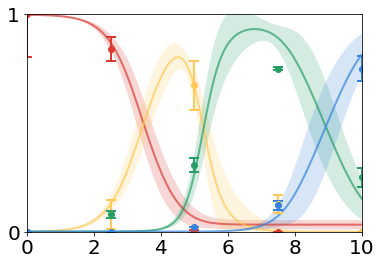

In [14]:
os.chdir("Paper Figures/Illustrator base svgs/supp-figure-5/")
np.random.seed(96)

for idx, currDatasetStr in enumerate(dataset_strings_pseudotime):

    # Randomly select a subset of kparam results
    fittedParam_random_sample = fittedParam_array[idx].sample(n=100, random_state=96)
    # Convert to list of tuples
    kparam_random_sample = fittedParam_random_sample.drop("σ", axis=1)
    kparam_random_sample = list(kparam_random_sample.itertuples(index=False, name=None))
    # Obtain the mean and std of the set of trajectories
    mean_trajectory, std_trajectory, t_eval = model_trajectory(kparam_random_sample)
    # Graph
    graph_trajectory(mean_trajectory, std_trajectory, t_eval, pseudotime_dfs[idx], stdev_dfs[idx], currDatasetStr[2:], condition_strings[idx])